# DAMO-630-29 Assignment 01

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sdv.metadata import Metadata
from sdv.single_table import GaussianCopulaSynthesizer, CTGANSynthesizer
from sdmetrics.reports.single_table import QualityReport, DiagnosticReport

## BUSINESS CHALLENGE #01

# TASK I - Exploratory Data Analysis

The EDA offers an initial overview of the dataset by inspecting its structure, detecting missing values or outliers, and applying descriptive statistics with visualizations. These insights provide the foundation for subsequent synthetic data generation and evaluation.

In [3]:
# 1.1. load dataset
df = pd.read_csv("Datasets\HealthInsurance.csv")  # adjust file name as needed

In [4]:
# 1.2. Shape
print("Shape:", df.shape)

Shape: (8802, 12)


In [5]:
# 1.3. Preview
display(df.head())

,rownames,health,age,limit,gender,insurance,married,selfemp,family,region,ethnicity,education
0,1,yes,31,no,male,yes,yes,yes,4,south,cauc,bachelor
1,2,yes,31,no,female,yes,yes,no,4,south,cauc,highschool
2,3,yes,54,no,male,yes,yes,no,5,west,cauc,ged
3,4,yes,27,no,male,yes,no,no,5,west,cauc,highschool
4,5,yes,39,no,male,yes,yes,no,5,west,cauc,none


In [6]:
# 1.4. Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8802 entries, 0 to 8801
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   rownames   8802 non-null   int64 
 1   health     8802 non-null   object
 2   age        8802 non-null   int64 
 3   limit      8802 non-null   object
 4   gender     8802 non-null   object
 5   insurance  8802 non-null   object
 6   married    8802 non-null   object
 7   selfemp    8802 non-null   object
 8   family     8802 non-null   int64 
 9   region     8802 non-null   object
 10  ethnicity  8802 non-null   object
 11  education  8802 non-null   object
dtypes: int64(3), object(9)
memory usage: 825.3+ KB


In [7]:
# 1.5. Descriptive statistics
display(df.describe())

,rownames,age,family
count,8802.000000,8802.000000,8802.000000
mean,4401.500000,38.936833,3.093501
std,2541.062868,11.110823,1.559633
min,1.000000,18.000000,1.000000
25%,2201.250000,30.000000,2.000000
50%,4401.500000,39.000000,3.000000
75%,6601.750000,48.000000,4.000000
max,8802.000000,62.000000,14.000000


rownames     0
health       0
age          0
limit        0
gender       0
insurance    0
married      0
selfemp      0
family       0
region       0
ethnicity    0
education    0
dtype: int64


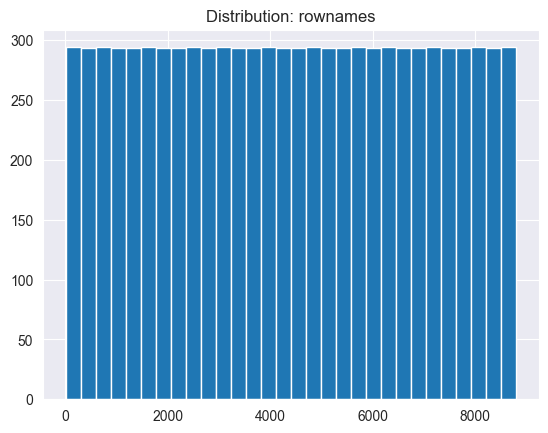

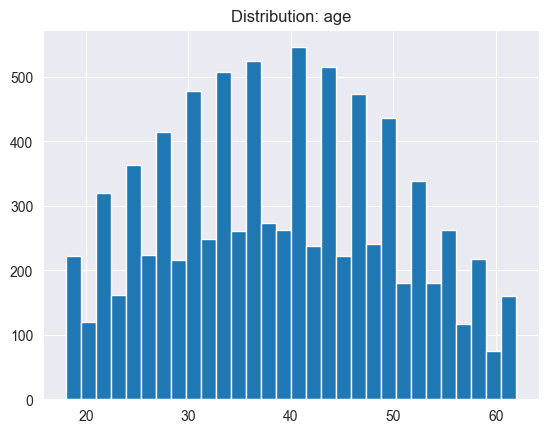

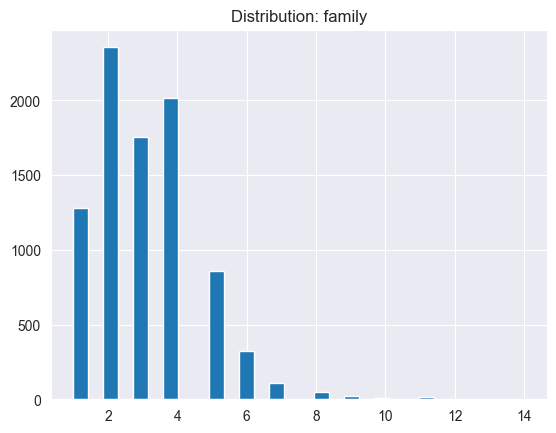

In [8]:
# 1.6. Missing values
print(df.isnull().sum())

# 1.7. Distribution plots (example numeric columns)
for col in df.select_dtypes(include=np.number).columns[:3]:
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f"Distribution: {col}")
    plt.show()

# Task II — Baseline Synthetic Data

In [9]:
# 2.1 Random noise baseline
synthetic_baseline = pd.DataFrame(
    np.random.randn(df.shape[0], df.shape[1]),
    columns=df.columns
)
display(synthetic_baseline.head())

,rownames,health,age,limit,gender,insurance,married,selfemp,family,region,ethnicity,education
0,0.630057,0.827503,-0.045768,0.081721,-1.343235,-0.912519,-1.040953,1.698231,-0.037190,-1.075166,-0.351867,0.589365
1,1.104413,-0.096961,-1.409344,0.302305,0.366294,-0.022432,1.454605,2.275556,1.092292,0.063952,0.268515,-0.569639
2,-0.056460,1.117921,0.432683,-1.254627,-1.336646,-0.535486,-0.597260,-0.124471,0.035849,-1.527702,-0.740304,-0.283435
3,2.003659,-1.067483,1.156021,-0.488883,-1.439160,-0.186931,1.782542,0.581280,0.814212,0.091027,0.494258,0.973689
4,0.617698,-0.715620,-0.433071,0.662798,-0.011046,-0.443538,-2.434723,1.222431,-0.002762,-1.866315,1.618151,-1.031235


# Task III — Advanced Synthetic Data (SDV)

In [10]:
# 3.1 Infer table metadata (types, constraints, relations)
metadata = Metadata.detect_from_dataframe(data=df, table_name="my_table")

In [11]:
# 3.2 GaussianCopula
gc = GaussianCopulaSynthesizer(metadata)
gc.fit(df)
synthetic_gc = gc.sample(num_rows=len(df))
display(synthetic_gc.head())

C:\Users\fabio\PycharmProjects\UNFTERM4\.venv\Lib\site-packages\sdv\single_table\base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


,rownames,health,age,limit,gender,insurance,married,selfemp,family,region,ethnicity,education
0,11478456,yes,42,no,male,yes,yes,no,3,west,cauc,highschool
1,5376530,yes,21,no,female,no,no,no,2,west,cauc,highschool
2,3720715,yes,22,no,male,no,no,no,3,south,afam,highschool
3,13670850,yes,56,no,female,yes,no,no,2,midwest,cauc,highschool
4,7487644,yes,47,no,female,yes,no,no,3,south,cauc,highschool


In [ ]:
# 3.3 CTGAN
ctgan = CTGANSynthesizer(metadata, epochs=200, batch_size=100, verbose=True)
ctgan.fit(df)
synthetic_ctgan = ctgan.sample(num_rows=len(df))
display(synthetic_ctgan.head())

Gen. (-2.56) | Discrim. (-0.29):  13%|█▎        | 26/200 [00:53<05:35,  1.93s/it]

# Task IV — Evaluation

Convert metadata for sdmetrics (single table)

In [ ]:
# Convert metadata for sdmetrics (single table)
_meta_dict = metadata.to_dict()
if "tables" in _meta_dict:
    _table_name = next(iter(_meta_dict["tables"].keys()))
    single_table_meta = _meta_dict["tables"][_table_name]
else:
    single_table_meta = _meta_dict

In [ ]:
# 4.1 Quality and Diagnostics
qr_gc = QualityReport(); qr_gc.generate(df, synthetic_gc, single_table_meta)
qr_ct = QualityReport(); qr_ct.generate(df, synthetic_ctgan, single_table_meta)

print("Quality — GC:", qr_gc.get_score())
print("Quality — CTGAN:", qr_ct.get_score())

dr_gc = DiagnosticReport(); dr_gc.generate(df, synthetic_gc, single_table_meta)
dr_ct = DiagnosticReport(); dr_ct.generate(df, synthetic_ctgan, single_table_meta)

In [ ]:
# 4.2 Correlation Preservation
def corr_rmse(a, b):
    cols = a.select_dtypes(include=np.number).columns.intersection(
        b.select_dtypes(include=np.number).columns
    )
    if len(cols) < 2:
        return np.nan
    ca, cb = a[cols].corr(), b[cols].corr()
    mask = np.triu(np.ones_like(ca, dtype=bool), k=1)
    diff = (ca - cb).where(mask)
    vals = diff.values[~np.isnan(diff.values)]
    return np.sqrt(np.mean(vals**2)) if len(vals) else np.nan

print("Correlation RMSE — GC:", corr_rmse(df, synthetic_gc))
print("Correlation RMSE — CTGAN:", corr_rmse(df, synthetic_ctgan))

In [ ]:
# 4.3 Utility — TSTR (Train on Synthetic, Test on Real)
def tstr_classification(real_df, synth_df, target):
    Xs, ys = synth_df.drop(columns=[target]), synth_df[target]
    Xr, yr = real_df.drop(columns=[target]), real_df[target]
    Xs = Xs.select_dtypes(include=np.number).fillna(Xs.median(numeric_only=True))
    Xr = Xr.select_dtypes(include=np.number).fillna(Xr.median(numeric_only=True))
    clf = RandomForestClassifier(n_estimators=300, random_state=42)
    clf.fit(Xs, ys)
    pred = clf.predict(Xr)
    out = {
        "accuracy": accuracy_score(yr, pred),
        "f1_macro": f1_score(yr, pred, average="macro")
    }
    if len(clf.classes_) == 2:
        out["roc_auc"] = roc_auc_score(yr, clf.predict_proba(Xr)[:, 1])
    return out

def tstr_regression(real_df, synth_df, target):
    Xs, ys = synth_df.drop(columns=[target]), synth_df[target]
    Xr, yr = real_df.drop(columns=[target]), real_df[target]
    Xs = Xs.select_dtypes(include=np.number).fillna(Xs.median(numeric_only=True))
    Xr = Xr.select_dtypes(include=np.number).fillna(Xr.median(numeric_only=True))
    reg = RandomForestRegressor(n_estimators=400, random_state=42)
    reg.fit(Xs, ys)
    pred = reg.predict(Xr)
    return {"r2": r2_score(yr, pred), "mae": mean_absolute_error(yr, pred)}

# Example (uncomment and set target column)
# print(tstr_classification(df, synthetic_gc, "your_target"))
# print(tstr_classification(df, synthetic_ctgan, "your_target"))

In [ ]:
# 4.4 Privacy — exact duplicates
def exact_dup_rate(real_df, synth_df):
    r = real_df.astype(str).agg("|".join, axis=1)
    s = synth_df.astype(str).agg("|".join, axis=1)
    return len(set(r) & set(s)) / max(1, len(s))

print("Duplication rate — GC:", exact_dup_rate(df, synthetic_gc))
print("Duplication rate — CTGAN:", exact_dup_rate(df, synthetic_ctgan))

## BUSINESS CHALLENGE #02

Preparation

In [1]:
import os, subprocess, sys

# 1) Point to your Temurin JDK 17 install (adjust if your folder name differs)
os.environ["JAVA_HOME"] = r"C:\Program Files\Eclipse Adoptium\jdk-17"
os.environ["PATH"] = os.environ["JAVA_HOME"] + r"\bin;" + os.environ["PATH"]

# 2) Quick check: Java visible to this kernel?
try:
    out = subprocess.check_output(["java", "-version"], stderr=subprocess.STDOUT)
    print(out.decode("utf-8"))
except Exception as e:
    print("Java not visible to the kernel:", e)

# 3) (Optional) Confirm PySpark version
try:
    import pyspark
    print("PySpark:", pyspark.__version__)
except Exception as e:
    print("PySpark not importable:", e, "\nTip: pip install -U 'pyspark>=3.5,<4.0'")


openjdk version "17.0.16" 2025-07-15
OpenJDK Runtime Environment Temurin-17.0.16+8 (build 17.0.16+8)
OpenJDK 64-Bit Server VM Temurin-17.0.16+8 (build 17.0.16+8, mixed mode, sharing)

PySpark: 3.5.7


Create SparkSession

In [ ]:
# =========================
# BC2 — Setup (PySpark)
# =========================

Load parquet file - dataset